In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# read mr and ct datasets
MR_train_address = 'drive/MyDrive/MR_CT_data/train_input.npy'
CT_train_address = 'drive/MyDrive/MR_CT_data/train_output.npy'

MR_val_address = 'drive/MyDrive/MR_CT_data/val_input.npy'
CT_val_address = 'drive/MyDrive/MR_CT_data/val_output.npy'

MR_test_address = 'drive/MyDrive/MR_CT_data/test_input.npy'
CT_test_address = 'drive/MyDrive/MR_CT_data/test_output.npy'

mr_train = np.load(MR_train_address)
ct_train = np.load(CT_train_address)

mr_val = np.load(MR_val_address)
ct_val = np.load(CT_val_address)

mr_test = np.load(MR_test_address)
ct_test = np.load(CT_test_address)

In [5]:
# resizes a 1d numpy array to an arbitrary size
def resize(img, size):

  img = img.astype('float32')
  img = torch.tensor(img)
  img = img.unsqueeze(0)

  transform = T.Resize(size)
  resized_img = transform(img)

  # resized_img = np.array(resized_img)

  return resized_img

In [6]:
change_gray_level = T.Compose([
    T.Lambda(lambda t: t * 0.2)
])

horizontal_flip = T.Compose([
    T.functional.hflip
])

vertical_flip = T.Compose([
    T.functional.vflip
])

rotate_45 = T.Compose([
    T.Lambda(lambda t: T.functional.rotate(t, angle=45))
])

rotate_minus_45 = T.Compose([
    T.Lambda(lambda t: T.functional.rotate(t, angle=-45))
])

In [7]:
n_train_samples = ct_train.shape[0]
n_val_samples = ct_val.shape[0]
n_test_samples = ct_test.shape[0]

# remove 90 samples from test data and add it to train data
n_add_from_test_to_train = 150

n_train_new = n_train_samples + n_val_samples + n_add_from_test_to_train
n_test_new = n_test_samples - n_add_from_test_to_train

# data augmentation
# add 5 varient of each sample
# so our train dataset will be 6 times bigger

# n_train_new = n_train_new * 6
# n_train_new = n_train_new * 3
# n_train_new = n_train_new * 2

mr_train_resized = [None] * n_train_new
ct_train_resized = [None] * n_train_new

mr_test_resized = [None] * n_test_new
ct_test_resized = [None] * n_test_new

# train samples with augmentation
for i in range(n_train_samples):

#   j = i * 6
  # j = i*3
  j = i
  # j = i*2

  resized_mr = resize(mr_train[i], 128)

  mr_train_resized[j] = resized_mr
  # mr_train_resized[j+1] = change_gray_level(resized_mr)
  # mr_train_resized[j+1] = horizontal_flip(resized_mr)
  # mr_train_resized[j+2] = vertical_flip(resized_mr)
  # mr_train_resized[j+1] = rotate_45(resized_mr)
  # mr_train_resized[j+2] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_train[i], 128)

  ct_train_resized[j] = resized_ct
  # ct_train_resized[j+1] = change_gray_level(resized_ct)
  # ct_train_resized[j+1] = horizontal_flip(resized_ct)
  # ct_train_resized[j+2] = vertical_flip(resized_ct)
  # ct_train_resized[j+1] = rotate_45(resized_ct)
  # ct_train_resized[j+2] = rotate_minus_45(resized_ct)


# validation samples with augmentation
for i in range(n_val_samples):

#   j = i*6 + n_train_samples*6
  # j = i*3 + n_train_samples*3
  j = i + n_train_samples
  # j = i*2 + n_train_samples*2

  resized_mr = resize(mr_val[i], 128)

  mr_train_resized[j] = resized_mr
  # mr_train_resized[j+1] = change_gray_level(resized_mr)
  # mr_train_resized[j+1] = horizontal_flip(resized_mr)
  # mr_train_resized[j+2] = vertical_flip(resized_mr)
  # mr_train_resized[j+1] = rotate_45(resized_mr)
  # mr_train_resized[j+2] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_val[i], 128)

  ct_train_resized[j] = resized_ct
  # ct_train_resized[j+1] = change_gray_level(resized_ct)
  # ct_train_resized[j+1] = horizontal_flip(resized_ct)
  # ct_train_resized[j+2] = vertical_flip(resized_ct)
  # ct_train_resized[j+1] = rotate_45(resized_ct)
  # ct_train_resized[j+2] = rotate_minus_45(resized_ct)


# part of test samples with augmentation

for i in range(n_add_from_test_to_train):

#   j = i*6 + n_train_samples*6 + n_val_samples*6
  # j = i*3 + n_train_samples*3 + n_val_samples*3
  # j = i + n_train_samples + n_val_samples
  j = i + n_train_samples + n_val_samples
  # j = i + n_train_samples*2 + n_val_samples*2

  resized_mr = resize(mr_test[i], 128)

  mr_train_resized[j] = resized_mr
  # mr_train_resized[j+1] = change_gray_level(resized_mr)
  # mr_train_resized[j+1] = horizontal_flip(resized_mr)
  # mr_train_resized[j+2] = vertical_flip(resized_mr)
  # mr_train_resized[j+1] = rotate_45(resized_mr)
  # mr_train_resized[j+2] = rotate_minus_45(resized_mr)

  resized_ct = resize(ct_test[i], 128)

  ct_train_resized[j] = resized_ct
  # ct_train_resized[j+1] = change_gray_level(resized_ct)
  # ct_train_resized[j+1] = horizontal_flip(resized_ct)
  # ct_train_resized[j+2] = vertical_flip(resized_ct)
  # ct_train_resized[j+1] = rotate_45(resized_ct)
  # ct_train_resized[j+2] = rotate_minus_45(resized_ct)

# test samples
for i in range(n_test_new):

  j = i + n_add_from_test_to_train

  mr_test_resized[i] = resize(mr_test[j], 128)
  ct_test_resized[i] = resize(ct_test[j], 128)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [8]:
# convert train and test samples to numpy array
for i in range(n_train_new):
  mr_train_resized[i] = np.array(mr_train_resized[i].squeeze())
  ct_train_resized[i] = np.array(ct_train_resized[i].squeeze())

for i in range(n_test_new):
  mr_test_resized[i] = np.array(mr_test_resized[i].squeeze())
  ct_test_resized[i] = np.array(ct_test_resized[i].squeeze())

In [9]:
# convert lists of mr and ct to numpy arrays
mr_train_resized = np.array(mr_train_resized)

ct_train_resized = np.array(ct_train_resized)

mr_test_resized = np.array(mr_test_resized)

ct_test_resized = np.array(ct_test_resized)


print('train images shape:', mr_train_resized.shape)
print('test images shape:', mr_test_resized.shape)

train images shape: (810, 128, 128)
test images shape: (0,)


In [10]:
import h5py

k = 81
fold_size = int(n_train_new / k)

mr_train_all_folds = ()
ct_train_all_folds = ()

for i in range(k):

  mr_fold = mr_train_resized[i*fold_size:(i+1)*fold_size]
  ct_fold = ct_train_resized[i*fold_size:(i+1)*fold_size]

  with h5py.File(f'mr_test{i+1}.hdf5', 'w') as f:
    dset = f.create_dataset("data", data = mr_fold)

  with h5py.File(f'ct_test{i+1}.hdf5', 'w') as f:
      dset = f.create_dataset("data", data = ct_fold)

  mr_train_all_folds += (mr_fold,)
  ct_train_all_folds += (ct_fold,)

In [11]:
for i in range(k):

  mr_train_all_folds_lst = list(mr_train_all_folds)
  ct_train_all_folds_lst = list(ct_train_all_folds)

  mr_train_all_folds_lst.pop(i)
  ct_train_all_folds_lst.pop(i)

  mr_train = tuple(mr_train_all_folds_lst)
  ct_train = tuple(ct_train_all_folds_lst)

  mr_train = np.vstack(mr_train)
  ct_train = np.vstack(ct_train)

  with h5py.File(f'mr_train{i+1}.hdf5', 'w') as f:
    dset = f.create_dataset("data", data = mr_train)

  with h5py.File(f'ct_train{i+1}.hdf5', 'w') as f:
      dset = f.create_dataset("data", data = ct_train)

In [12]:
# perform data augmentation on training data with fold number specified
def augment(fold):

  mr_path = f'mr_train{fold}.hdf5'
  f = h5py.File(mr_path,'r')
  mr_data = f['data']
  n_mr_samples = len(mr_data)

  ct_path = f'ct_train{fold}.hdf5'
  f = h5py.File(ct_path,'r')
  ct_data = f['data']
  n_ct_samples = len(ct_data)

  mr_augmented = [None] * n_mr_samples*2
  ct_augmented = [None] * n_ct_samples*2

  for i in range(n_mr_samples):

    j = i*2

    mr_sample = mr_data[i]
    mr_augmented[j] = mr_sample
    mr_augmented[j+1] = change_gray_level(mr_sample)

    ct_sample = ct_data[i]
    ct_augmented[j] = ct_sample
    ct_augmented[j+1] = change_gray_level(ct_sample)


  with h5py.File(f'mr_train_augmented{fold}.hdf5', 'w') as f:
      dset = f.create_dataset("data", data = mr_augmented)

  with h5py.File(f'ct_train_augmented{fold}.hdf5', 'w') as f:
      dset = f.create_dataset("data", data = ct_augmented)

In [13]:
augment(fold=1)

In [14]:
path = 'ct_train_augmented1.hdf5'
f = h5py.File(path,'r')
load_data = f['data']
# plt.imshow(load_data[0], cmap='gray')
(load_data.shape)

(1600, 128, 128)

In [15]:
# dataset.py DDPM folder
import random
import numpy as np
import torch
import h5py
from torch.utils.data import Dataset
from torchvision import transforms

def random_rot(img1,img2):
    k = np.random.randint(0, 3)
    img1 = np.rot90(img1, k+1)
    img2 = np.rot90(img2, k+1)
    return img1,img2

def random_flip(img1,img2):
    axis = np.random.randint(0, 2)
    img1 = np.flip(img1, axis=axis).copy()
    img2 = np.flip(img2, axis=axis).copy()
    return img1,img2

class RandomGenerator(object):
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, sample):
        lr, hr = sample['lr'], sample['hr']

        if random.random() > 0.5:
            lr, hr = random_rot(lr, hr)
        if random.random() > 0.5:
            lr, hr = random_flip(lr, hr)
        sample = {'lr': lr,'hr': hr}
        return sample



class Train_Data(Dataset):
    def __init__(self, mr_path, ct_path):
        path = mr_path
        f = h5py.File(path,'r')
        load_data = f['data']
        self.lr = load_data
        path = ct_path
        f = h5py.File(path,'r')
        load_data = f['data']
        self.hr = load_data
        c, self.h, self.w = self.lr.shape

        self.len = c
        self.transform=transforms.Compose([RandomGenerator(output_size=[self.h, self.w])])

    def __getitem__(self, index):
        x = self.lr[index, :, :]
        y = self.hr[index, :, :]

        x = self.norm(x)
        y = self.norm(y)

        sample = {'lr': x,'hr': y}
        if self.transform:
            sample = self.transform(sample)

        x, y = sample['lr'], sample['hr']

        xx = np.zeros((1, self.h, self.w))
        yy = np.zeros((1, self.h, self.w))

        xx[0,:,:] = x.copy()
        yy[0,:,:] = y.copy()

        xx = torch.from_numpy(xx)
        yy = torch.from_numpy(yy)

        xx = xx.type(torch.FloatTensor)
        yy = yy.type(torch.FloatTensor)

        return xx, yy

    def __len__(self):
        return self.len

    def norm(self, x):
        if np.amax(x) > 0:
            x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
        return x


class Valid_Data(Dataset):
    def __init__(self, mr_path, ct_path):
        path = mr_path
        f = h5py.File(path,'r')
        load_data = f['data']
        self.lr = load_data
        path = ct_path
        f = h5py.File(path,'r')
        load_data = f['data']
        self.hr = load_data
        c, self.h, self.w = self.lr.shape

        self.len = c

    def __getitem__(self, index):
        x = self.lr[index, :, :]
        y = self.hr[index, :, :]

        x = self.norm(x)
        y = self.norm(y)

        xx = np.zeros((1, self.h, self.w))
        yy = np.zeros((1, self.h, self.w))

        xx[0,:,:] = x.copy()
        yy[0,:,:] = y.copy()

        xx = torch.from_numpy(xx)
        yy = torch.from_numpy(yy)

        xx = xx.type(torch.FloatTensor)
        yy = yy.type(torch.FloatTensor)

        return xx, yy

    def __len__(self):
        return self.len

    def norm(self, x):
        if np.amax(x) > 0:
            x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
        return x

class Test_Data(Dataset):
    def __init__(self):
        path = '/path/to/test_mri_data'
        f = h5py.File(path,'r')
        load_data = f['data']
        self.lr = load_data
        path = '/path/to/test_ct_data'
        f = h5py.File(path,'r')
        load_data = f['data']
        self.hr = load_data
        c, self.h, self.w = self.lr.shape

        self.len = 135

    def __getitem__(self, index):
        x = self.lr[index, :, :]
        y = self.hr[index, :, :]

        x = self.norm(x)
        y = self.norm(y)

        xx = np.zeros((1, self.h, self.w))
        yy = np.zeros((1, self.h, self.w))

        xx[0,:,:] = x.copy()
        yy[0,:,:] = y.copy()

        xx = torch.from_numpy(xx)
        yy = torch.from_numpy(yy)

        xx = xx.type(torch.FloatTensor)
        yy = yy.type(torch.FloatTensor)

        return xx, yy

    def __len__(self):
        return self.len

    def norm(self, x):
        if np.amax(x) > 0:
            x = (x - np.amin(x)) / (np.amax(x) - np.amin(x))
        return x

In [16]:
# diffusion.py DDPM folder
import torch
import torch.nn as nn
import torch.nn.functional as F


def extract(v, t, x_shape):
    """
    Extract some coefficients at specified timesteps, then reshape to
    [batch_size, 1, 1, 1, 1, ...] for broadcasting purposes.
    """
    out = torch.gather(v, index=t, dim=0).float()
    return out.view([t.shape[0]] + [1] * (len(x_shape) - 1))


class GaussianDiffusionTrainer(nn.Module):
    def __init__(self, model, beta_1, beta_T, T):
        super().__init__()

        self.model = model
        self.T = T

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_alphas_bar', torch.sqrt(alphas_bar))
        self.register_buffer(
            'sqrt_one_minus_alphas_bar', torch.sqrt(1. - alphas_bar))

    def forward(self, x_0, condition):
        """
        Algorithm 1.
        """
        t = torch.randint(self.T, size=(x_0.shape[0], ), device=x_0.device)
        noise = torch.randn_like(x_0)
        x_t = (
            extract(self.sqrt_alphas_bar, t, x_0.shape) * x_0 +
            extract(self.sqrt_one_minus_alphas_bar, t, x_0.shape) * noise)

        x_recon = self.model(torch.cat([x_t, condition], dim=1), t)

        loss = F.mse_loss(x_recon, noise, reduction='none').mean()
        return loss


class GaussianDiffusionSampler(nn.Module):
    def __init__(self, model, beta_1, beta_T, T, img_size=32,
                 mean_type='epsilon', var_type='fixedlarge'):
        assert mean_type in ['xprev' 'xstart', 'epsilon']
        assert var_type in ['fixedlarge', 'fixedsmall']
        super().__init__()

        self.model = model
        self.T = T
        self.img_size = img_size
        self.mean_type = mean_type
        self.var_type = var_type

        self.register_buffer(
            'betas', torch.linspace(beta_1, beta_T, T).double())
        alphas = 1. - self.betas
        alphas_bar = torch.cumprod(alphas, dim=0)
        alphas_bar_prev = F.pad(alphas_bar, [1, 0], value=1)[:T]

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer(
            'sqrt_recip_alphas_bar', torch.sqrt(1. / alphas_bar))
        self.register_buffer(
            'sqrt_recipm1_alphas_bar', torch.sqrt(1. / alphas_bar - 1))

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        self.register_buffer(
            'posterior_var',
            self.betas * (1. - alphas_bar_prev) / (1. - alphas_bar))
        # below: log calculation clipped because the posterior variance is 0 at
        # the beginning of the diffusion chain
        self.register_buffer(
            'posterior_log_var_clipped',
            torch.log(
                torch.cat([self.posterior_var[1:2], self.posterior_var[1:]])))
        self.register_buffer(
            'posterior_mean_coef1',
            torch.sqrt(alphas_bar_prev) * self.betas / (1. - alphas_bar))
        self.register_buffer(
            'posterior_mean_coef2',
            torch.sqrt(alphas) * (1. - alphas_bar_prev) / (1. - alphas_bar))

    def q_mean_variance(self, x_0, x_t, t):
        """
        Compute the mean and variance of the diffusion posterior
        q(x_{t-1} | x_t, x_0)
        """
        assert x_0.shape == x_t.shape
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_0 +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_log_var_clipped = extract(
            self.posterior_log_var_clipped, t, x_t.shape)
        return posterior_mean, posterior_log_var_clipped

    def predict_xstart_from_eps(self, x_t, t, eps):
        assert x_t.shape == eps.shape
        return (
            extract(self.sqrt_recip_alphas_bar, t, x_t.shape) * x_t -
            extract(self.sqrt_recipm1_alphas_bar, t, x_t.shape) * eps
        )

    def predict_xstart_from_xprev(self, x_t, t, xprev):
        assert x_t.shape == xprev.shape
        return (  # (xprev - coef2*x_t) / coef1
            extract(
                1. / self.posterior_mean_coef1, t, x_t.shape) * xprev -
            extract(
                self.posterior_mean_coef2 / self.posterior_mean_coef1, t,
                x_t.shape) * x_t
        )

    def p_mean_variance(self, x_t, condition, t):
        # below: only log_variance is used in the KL computations
        # model_log_var = {
        #     # for fixedlarge, we set the initial (log-)variance like so to
        #     # get a better decoder log likelihood
        #     'fixedlarge': torch.log(torch.cat([self.posterior_var[1:2],
        #                                        self.betas[1:]])),
        #     'fixedsmall': self.posterior_log_var_clipped,
        # }[self.var_type]
        # model_log_var = extract(model_log_var, t, x_t.shape)

        # Mean parameterization
        if self.mean_type == 'xprev':       # the model predicts x_{t-1}
            x_prev = self.model(x_t, t)
            x_0 = self.predict_xstart_from_xprev(x_t, t, xprev=x_prev)
            model_mean = x_prev
        elif self.mean_type == 'xstart':    # the model predicts x_0
            x_0 = self.model(x_t, t)
            model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        elif self.mean_type == 'epsilon':   # the model predicts epsilon
            eps = self.model(torch.cat([x_t, condition], dim=1), t)
            x_0 = self.predict_xstart_from_eps(x_t, t, eps=eps)
            # model_mean, _ = self.q_mean_variance(x_0, x_t, t)
        else:
            raise NotImplementedError(self.mean_type)
        x_0 = torch.clamp(x_0, 0., 1.)
        model_mean, model_log_var = self.q_mean_variance(x_0, x_t, t)

        return model_mean, model_log_var

    def forward(self, x_T, condition):
        """
        Algorithm 2.
        """
        out = []
        x_t = x_T
        for time_step in reversed(range(self.T)):
            t = x_t.new_ones([x_T.shape[0], ], dtype=torch.long) * time_step
            mean, log_var = self.p_mean_variance(x_t=x_t, condition=condition, t=t)
            # no noise when t == 0
            if time_step > 0:
                noise = torch.randn_like(x_t)
            else:
                noise = 0
            x_t = mean + torch.exp(0.5 * log_var) * noise

            if time_step == (self.T-1):
                out.append(x_t)

            if time_step % 250 == 0:
                out.append(x_t)

        return out

In [17]:
# model.py DDPM folder
import torch
from torch import nn
from torch.nn import init
from torch.nn import functional as F
from torchvision import models
from collections import namedtuple
import numpy as np


class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)


class TimeEmbedding(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights druing initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :].to(x.device) * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class DownSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=2, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        x = self.main(x)
        return x


class UpSample(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.main = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.main.weight)
        init.zeros_(self.main.bias)

    def forward(self, x, temb):
        _, _, H, W = x.shape
        x = F.interpolate(
            x, scale_factor=2, mode='nearest')
        x = self.main(x)
        return x


class AttnBlock(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.group_norm = nn.GroupNorm(32, in_ch)
        self.proj_q = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_k = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj_v = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.proj = nn.Conv2d(in_ch, in_ch, 1, stride=1, padding=0)
        self.initialize()

    def initialize(self):
        for module in [self.proj_q, self.proj_k, self.proj_v, self.proj]:
            init.xavier_uniform_(module.weight)
            init.zeros_(module.bias)
        init.xavier_uniform_(self.proj.weight, gain=1e-5)

    def forward(self, x):
        B, C, H, W = x.shape
        h = self.group_norm(x)
        q = self.proj_q(h)
        k = self.proj_k(h)
        v = self.proj_v(h)

        q = q.permute(0, 2, 3, 1).view(B, H * W, C)
        k = k.view(B, C, H * W)
        w = torch.bmm(q, k) * (int(C) ** (-0.5))
        assert list(w.shape) == [B, H * W, H * W]
        w = F.softmax(w, dim=-1)

        v = v.permute(0, 2, 3, 1).view(B, H * W, C)
        h = torch.bmm(w, v)
        assert list(h.shape) == [B, H * W, C]
        h = h.view(B, H, W, C).permute(0, 3, 1, 2)
        h = self.proj(h)

        return x + h


class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, tdim, dropout, attn=False):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.GroupNorm(32, in_ch),
            Swish(),
            nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1),
        )
        self.temb_proj = nn.Sequential(
            Swish(),
            nn.Linear(tdim, out_ch),
        )
        self.block2 = nn.Sequential(
            nn.GroupNorm(32, out_ch),
            Swish(),
            nn.Dropout(dropout),
            nn.Conv2d(out_ch, out_ch, 3, stride=1, padding=1),
        )
        if in_ch != out_ch:
            self.shortcut = nn.Conv2d(in_ch, out_ch, 1, stride=1, padding=0)
        else:
            self.shortcut = nn.Identity()
        if attn:
            self.attn = AttnBlock(out_ch)
        else:
            self.attn = nn.Identity()
        self.initialize()

    def initialize(self):
        for module in self.modules():
            if isinstance(module, (nn.Conv2d, nn.Linear)):
                init.xavier_uniform_(module.weight)
                init.zeros_(module.bias)
        init.xavier_uniform_(self.block2[-1].weight, gain=1e-5)

    def forward(self, x, temb):
        h = self.block1(x) # [batch, out_ch, h, w]
        h += self.temb_proj(temb)[:, :, None, None] # [batch, out_ch, :, :]
        h = self.block2(h) # [batch, out_ch, h, w]

        h = h + self.shortcut(x)
        h = self.attn(h)
        return h


class UNet(nn.Module):
    def __init__(self, T, ch, ch_mult, attn, num_res_blocks, dropout):
        super().__init__()
        assert all([i < len(ch_mult) for i in attn]), 'attn index out of bound'
        tdim = ch * 4
        self.time_embedding = TimeEmbedding(tdim)
        # self.time_embedding = TimeEmbedding(T, ch, tdim)

        self.head = nn.Conv2d(2, ch, kernel_size=3, stride=1, padding=1)
        self.downblocks = nn.ModuleList()
        chs = [ch]  # record output channel when dowmsample for upsample
        now_ch = ch
        for i, mult in enumerate(ch_mult):
            out_ch = ch * mult
            for _ in range(num_res_blocks):
                self.downblocks.append(ResBlock(
                    in_ch=now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=False))
                now_ch = out_ch
                chs.append(now_ch)
            if i != len(ch_mult) - 1:
                self.downblocks.append(DownSample(now_ch))
                chs.append(now_ch)

        self.middleblocks = nn.ModuleList([
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
            ResBlock(now_ch, now_ch, tdim, dropout, attn=False),
        ])

        self.upblocks = nn.ModuleList()
        for i, mult in reversed(list(enumerate(ch_mult))):
            out_ch = ch * mult
            for _ in range(num_res_blocks + 1):
                self.upblocks.append(ResBlock(
                    in_ch=chs.pop() + now_ch, out_ch=out_ch, tdim=tdim,
                    dropout=dropout, attn=False))
                now_ch = out_ch
            if i != 0:
                self.upblocks.append(UpSample(now_ch))
        assert len(chs) == 0

        self.tail = nn.Sequential(
            nn.GroupNorm(32, now_ch),
            Swish(),
            nn.Conv2d(now_ch, 1, 3, stride=1, padding=1)
        )
        self.initialize()

    def initialize(self):
        init.xavier_uniform_(self.head.weight)
        init.zeros_(self.head.bias)
        init.xavier_uniform_(self.tail[-1].weight, gain=1e-5)
        init.zeros_(self.tail[-1].bias)

    def forward(self, x, t):  # t [batch,], x [batch,3,h,w]
        # Timestep embedding
        temb = self.time_embedding(t) # [batch, 128*4]
        # Downsampling
        h = self.head(x) # [batch,128,h,w]
        hs = [h]
        for layer in self.downblocks: # [res, res, down; res, res, down; res, res, down; res, res]
            h = layer(h, temb)
            hs.append(h)
        # Middle
        for layer in self.middleblocks: # [res, res]
            h = layer(h, temb)
        # Upsampling
        for layer in self.upblocks: # [res,res,res; res,res,res,up; res,res,res,up; res,res,res,up]
            if isinstance(layer, ResBlock):
                h = torch.cat([h, hs.pop()], dim=1)
            h = layer(h, temb)
        h = self.tail(h)

        assert len(hs) == 0
        return h



In [18]:
# train.py DDPM folder
import sys
import copy
import os
import warnings
import scipy.io as sio
from absl import app, flags
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import gridspec

import torch
from torch.utils.data import DataLoader

# from diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler
# from model import UNet
# from Dataset.dataset import Train_Data, Valid_Data


train = True
continue_train = False

# UNet
ch = 64
ch_mult = [1, 2, 2, 4, 4]
attn = [1]
num_res_blocks = 2
dropout = 0.

# Gaussian Diffusion
beta_1 = 1e-4
beta_T = 0.02
T = 1000

# Training
lr = 1e-4
grad_clip = 1.
img_size = 128
batch_size = 2
num_workers = 1
ema_decay = 0.9999

sample_size = 1
max_epoch = 5000
# max_epoch = 1

epoch_mean_loss = max_epoch * [None]
n_prev_epochs = 20
# Logging & Sampling
DIREC = f'ddpm-unet_epochs_{max_epoch}_n-train-samples_{n_train_new}_batch-size_{batch_size}_T_{T}_img-size_{img_size}_{k}fold_cross_validation'

# device = torch.device('cuda:0')


def ema(source, target, decay):
    source_dict = source.state_dict()
    target_dict = target.state_dict()
    for key in source_dict.keys():
        target_dict[key].data.copy_(
            target_dict[key].data * decay +
            source_dict[key].data * (1 - decay))

def train(fold):
    print(f'start training with fold number {fold}')

    # dataset
    tr_train = Train_Data(mr_path=f'mr_train_augmented{fold}.hdf5', ct_path=f'ct_train_augmented{fold}.hdf5')
    trainloader = DataLoader(tr_train, batch_size=batch_size, num_workers=num_workers,
                            pin_memory=True, shuffle=True)
    va_train = Valid_Data(mr_path=f'mr_test{fold}.hdf5', ct_path=f'ct_test{fold}.hdf5')
    validloader = DataLoader(va_train, batch_size=sample_size, num_workers=num_workers,
                              pin_memory=True, shuffle=False)

    # model setup
    net_model = UNet(
        T=T, ch=ch, ch_mult=ch_mult, attn=attn,
        num_res_blocks=num_res_blocks, dropout=dropout)
    ema_model = copy.deepcopy(net_model)


    optim = torch.optim.Adam(net_model.parameters(), lr=lr)

    trainer = GaussianDiffusionTrainer(
        net_model, beta_1, beta_T, T).to(device)
    ema_sampler = GaussianDiffusionSampler(
        ema_model, beta_1, beta_T, T, img_size).to(device)


    # show model size
    model_size = 0
    for param in net_model.parameters():
        model_size += param.data.nelement()
    print('Model params: %.2f M' % (model_size / 1024 / 1024))

    if continue_train:
        checkpoint = torch.load('./Save/' + DIREC + '/model_latest.pkl', map_location="cuda:0")
        net_model.load_state_dict(checkpoint['net_model'])
        ema_model.load_state_dict(checkpoint['ema_model'])
        optim.load_state_dict(checkpoint['optim'])
        restore_epoch = checkpoint['epoch']
        print('Finish loading model')
    else:
        restore_epoch = 0

    if not os.path.exists('Loss'):
        os.makedirs('Loss')

    tr_ls = []
    if continue_train:
        readmat = sio.loadmat('./Loss/' + DIREC)
        load_tr_ls = readmat['loss']
        for i in range(restore_epoch):
            tr_ls.append(load_tr_ls[0][i])
        print('Finish loading loss!')

    if not os.path.exists('./diff_results'):
        os.makedirs('./diff_results')

    for epoch in range(restore_epoch, max_epoch):
        with tqdm(trainloader, unit="batch") as tepoch:
            tmp_tr_loss = 0
            tr_sample = 0
            net_model.train()
            for data, target in tepoch:
                tepoch.set_description(f"Epoch {epoch+1}")

                # train
                optim.zero_grad()
                condition = data.to(device)
                x_0 = target.to(device)

                loss = trainer(x_0, condition)
                tmp_tr_loss += loss.item()
                tr_sample += len(data)

                loss.backward()

                torch.nn.utils.clip_grad_norm_(
                    net_model.parameters(), grad_clip)
                optim.step()
                ema(net_model, ema_model, ema_decay)

                tepoch.set_postfix({'Loss': loss.item()})

        mean_loss = tmp_tr_loss / tr_sample
        print('mean loss', mean_loss)

        epoch_mean_loss[epoch] = mean_loss

        if epoch > 100:
          prev_mean_loss = 0

          for i in range(n_prev_epochs):
            prev_mean_loss += epoch_mean_loss[epoch - (i+1)]

          prev_mean_loss /= n_prev_epochs
          # print('number of samples: ', tr_sample)
          # print('prev mean loss:', prev_mean_loss)
          if mean_loss > (prev_mean_loss - 0.01*prev_mean_loss):
            break

        tr_ls.append(tmp_tr_loss / tr_sample)
        sio.savemat('./Loss/' + DIREC +'.mat', {'loss': tr_ls})

        if not os.path.exists('Train_Output/' + DIREC):
            os.makedirs('Train_Output/' + DIREC)
        net_model.eval()
        if ((epoch+1) % 5 == 0) and (epoch+1) >= 80:
        # if epoch == 0:
            with torch.no_grad():
                for batch_idx, (data, target) in enumerate(validloader):
                    # if batch_idx == 0:
                        x_T = torch.randn(sample_size, 1, img_size, img_size)
                        x_T = x_T.to(device)

                        condition = data.to(device)
                        x_0 = ema_sampler(x_T, condition)

                        diff_out = x_0[-1]
                        diff_out = np.array(diff_out.cpu())

                        # x_0_copy = len(x_0) * [None]

                        # for i, img in enumerate(x_0):
                        #     img = np.array(img.cpu())
                        #     x_0_copy[i] = img

                        # x_0_copy = np.array(x_0_copy)
                        if not os.path.exists(f'./diff_results/fold{fold}'):
                          os.makedirs(f'./diff_results/fold{fold}')
                        save_path = f'./diff_results/fold{fold}/x0_number_{batch_idx+1}_epoch_{epoch+1}.npy'
                        np.save(save_path, diff_out)

                        # fig = plt.figure()
                        # fig.set_figheight(8)
                        # fig.set_figwidth(28)
                        # spec = gridspec.GridSpec(ncols=7, nrows=2,
                        #       width_ratios=[1,1,1,1,1,1,1], wspace=0.01,
                        #       hspace=0.01, height_ratios=[1,1],left=0,right=1,top=1,bottom=0)

                        # img = data[0].data.squeeze()
                        # ax = fig.add_subplot(spec[0])
                        # ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                        # ax.axis('off')
                        # # img = data[1].data.squeeze()
                        # # ax = fig.add_subplot(spec[7])
                        # # ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                        # # ax.axis('off')

                        # count = 1
                        # for kk in range(5): # x_0 [5,b,1,h,w]
                        #     imgs = x_0[kk] # imgs [b,1,h,w]
                        #     img = imgs[0].data.squeeze().cpu()
                        #     ax = fig.add_subplot(spec[count])
                        #     ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                        #     ax.axis('off')

                        #     # imgs = x_0[kk] # imgs [b,1,h,w]
                        #     # img = imgs[1].data.squeeze().cpu()
                        #     # ax = fig.add_subplot(spec[count+7])
                        #     # ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                        #     # ax.axis('off')

                        #     count += 1

                        # img = target[0].data.squeeze().cpu()
                        # ax = fig.add_subplot(spec[6])
                        # ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                        # ax.axis('off')
                        # # img = target[1].data.squeeze().cpu()
                        # # ax = fig.add_subplot(spec[13])
                        # # ax.imshow(img, cmap='gray', vmin=0,vmax=1)
                        # # ax.axis('off')

                        plt.savefig('./Train_Output/'+ DIREC + '/Epoch_' + str(epoch+1) + '.png',
                                    bbox_inches='tight', pad_inches=0)

                        # if not os.path.exists('Saved_model'):
                        #    os.makedirs('Saved_model')

                        # torch.save(ema_model.state_dict(), f'./Saved_model/ema_model_epoch_{epoch+1}.pt')

        # # save
        # if not os.path.exists('Save/' + DIREC):
        #     os.makedirs('Save/' + DIREC)
        # ckpt = {
        #     'net_model': net_model.state_dict(),
        #     'ema_model': ema_model.state_dict(),
        #     'optim': optim.state_dict(),
        #     'epoch': epoch+1,
        #     # 'x_T': x_T,
        # }
        # if (epoch+1) % 2 == 0:
        #     torch.save(ckpt, './Save/' + DIREC + '/model_epoch_'+str(epoch+1)+'.pkl')
        # torch.save(ckpt, './Save/' + DIREC + '/model_latest.pkl')

In [19]:
train(fold=1)
# train(fold=2)
# train(fold=3)
# train(fold=4)
# train(fold=5)

start training with fold number 1
Model params: 24.91 M


Epoch 1: 100%|██████████| 800/800 [02:01<00:00,  6.60batch/s, Loss=0.00659]


mean loss 0.031583229691314045


Epoch 2: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.0124]


mean loss 0.004729625778818445


Epoch 3: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.00127]


mean loss 0.004034085877956386


Epoch 4: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00608]


mean loss 0.003955395894627145


Epoch 5: 100%|██████████| 800/800 [01:50<00:00,  7.26batch/s, Loss=0.00113]


mean loss 0.003502561546101788


Epoch 6: 100%|██████████| 800/800 [01:51<00:00,  7.17batch/s, Loss=0.00194]


mean loss 0.0028635326533549233


Epoch 7: 100%|██████████| 800/800 [01:51<00:00,  7.20batch/s, Loss=0.0389]


mean loss 0.003282785247774882


Epoch 8: 100%|██████████| 800/800 [01:50<00:00,  7.27batch/s, Loss=0.002]


mean loss 0.0030446499165373096


Epoch 9: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.0201]


mean loss 0.0026268359334790147


Epoch 10: 100%|██████████| 800/800 [01:48<00:00,  7.34batch/s, Loss=0.00321]


mean loss 0.002866665845795069


Epoch 11: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.00186]


mean loss 0.0026417492241671424


Epoch 12: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.0128]


mean loss 0.0023039758836966937


Epoch 13: 100%|██████████| 800/800 [01:47<00:00,  7.43batch/s, Loss=0.00622]


mean loss 0.0024977922707239484


Epoch 14: 100%|██████████| 800/800 [01:48<00:00,  7.39batch/s, Loss=0.000402]


mean loss 0.0025094495856683354


Epoch 15: 100%|██████████| 800/800 [01:48<00:00,  7.40batch/s, Loss=0.00208]


mean loss 0.0023804175631084944


Epoch 16: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.000518]


mean loss 0.002020537058942864


Epoch 17: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.000729]


mean loss 0.0024312711718266653


Epoch 18: 100%|██████████| 800/800 [01:47<00:00,  7.42batch/s, Loss=0.000522]


mean loss 0.0018258366503050639


Epoch 19: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.000643]


mean loss 0.0022498922423073962


Epoch 20: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.000402]


mean loss 0.0019968558058644703


Epoch 21: 100%|██████████| 800/800 [01:48<00:00,  7.39batch/s, Loss=0.000345]


mean loss 0.0019891129445750266


Epoch 22: 100%|██████████| 800/800 [01:48<00:00,  7.41batch/s, Loss=0.000331]


mean loss 0.001975130588589309


Epoch 23: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.0148]


mean loss 0.0017294887246862346


Epoch 24: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.01]


mean loss 0.0019532144355616766


Epoch 25: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00107]


mean loss 0.0018645953183659004


Epoch 26: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.000436]


mean loss 0.0020258101488980175


Epoch 27: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.00081]


mean loss 0.0018269308419166918


Epoch 28: 100%|██████████| 800/800 [01:48<00:00,  7.39batch/s, Loss=0.000451]


mean loss 0.001807856478562826


Epoch 29: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.000379]


mean loss 0.001825720639071733


Epoch 30: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.00114]


mean loss 0.0017454032352543435


Epoch 31: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.00044]


mean loss 0.0013861087388795568


Epoch 32: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.000885]


mean loss 0.0016383030939232412


Epoch 33: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.00151]


mean loss 0.001830481382689868


Epoch 34: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.000212]


mean loss 0.0016369381387767135


Epoch 35: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00135]


mean loss 0.0016922141469740382


Epoch 36: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.00117]


mean loss 0.0016102516536602707


Epoch 37: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.00657]


mean loss 0.0017417962085619365


Epoch 38: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.00114]


mean loss 0.001482838370943682


Epoch 39: 100%|██████████| 800/800 [01:47<00:00,  7.41batch/s, Loss=0.00811]


mean loss 0.0018518234150542412


Epoch 40: 100%|██████████| 800/800 [01:48<00:00,  7.40batch/s, Loss=0.00209]


mean loss 0.0016218706665813442


Epoch 41: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.000865]


mean loss 0.0015282519900347324


Epoch 42: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.000426]


mean loss 0.0015755365500399422


Epoch 43: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.00044]


mean loss 0.001523303777748879


Epoch 44: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00142]


mean loss 0.001390840940516682


Epoch 45: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.0003]


mean loss 0.0014794752286479706


Epoch 46: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.000583]


mean loss 0.001547832161822953


Epoch 47: 100%|██████████| 800/800 [01:50<00:00,  7.25batch/s, Loss=0.00121]


mean loss 0.0018479745287413606


Epoch 48: 100%|██████████| 800/800 [01:50<00:00,  7.27batch/s, Loss=0.000193]


mean loss 0.0014754251098474925


Epoch 49: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.00659]


mean loss 0.0015835173780124024


Epoch 50: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00054]


mean loss 0.0016466270042928954


Epoch 51: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.00288]


mean loss 0.0012378155562782923


Epoch 52: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.00134]


mean loss 0.0015370240016773097


Epoch 53: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.00166]


mean loss 0.0014859065223936342


Epoch 54: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.000132]


mean loss 0.001401144995870709


Epoch 55: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.000614]


mean loss 0.0012716131173101531


Epoch 56: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00147]


mean loss 0.0015781116046082388


Epoch 57: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.0191]


mean loss 0.0012482302352646002


Epoch 58: 100%|██████████| 800/800 [01:49<00:00,  7.31batch/s, Loss=0.000974]


mean loss 0.0014015886522338406


Epoch 59: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.00279]


mean loss 0.00157955857372599


Epoch 60: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.000105]


mean loss 0.0013676135065770723


Epoch 61: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.00254]


mean loss 0.0010880711351865101


Epoch 62: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.00287]


mean loss 0.001231965436027167


Epoch 63: 100%|██████████| 800/800 [01:49<00:00,  7.31batch/s, Loss=0.00511]


mean loss 0.0013053250638381541


Epoch 64: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00544]


mean loss 0.001381773586726922


Epoch 65: 100%|██████████| 800/800 [01:48<00:00,  7.37batch/s, Loss=0.000722]


mean loss 0.001425995081272049


Epoch 66: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.000839]


mean loss 0.0013890524118005487


Epoch 67: 100%|██████████| 800/800 [01:48<00:00,  7.38batch/s, Loss=0.000205]


mean loss 0.001323027258968068


Epoch 68: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.000912]


mean loss 0.0012071682253554173


Epoch 69: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.00219]


mean loss 0.0014212194270612599


Epoch 70: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.000366]


mean loss 0.0012778461055677325


Epoch 71: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.00106]


mean loss 0.001242113324510683


Epoch 72: 100%|██████████| 800/800 [01:48<00:00,  7.34batch/s, Loss=0.000216]


mean loss 0.0014190511218066604


Epoch 73: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.000778]


mean loss 0.0013343489832277555


Epoch 74: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.000278]


mean loss 0.0011574659725556557


Epoch 75: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=8.8e-5]


mean loss 0.0010258716996168005


Epoch 76: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.0156]


mean loss 0.0013259334536519418


Epoch 77: 100%|██████████| 800/800 [01:48<00:00,  7.39batch/s, Loss=0.000151]


mean loss 0.0011594276727873876


Epoch 78: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.000292]


mean loss 0.001300042165235027


Epoch 79: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.000587]


mean loss 0.0010517346135293338


Epoch 80: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.00259]

mean loss 0.001214828489771662



Epoch 81: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.000211]


mean loss 0.0009792119263443055


Epoch 82: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.000669]


mean loss 0.001406734066486024


Epoch 83: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.000469]


mean loss 0.0011837985133229267


Epoch 84: 100%|██████████| 800/800 [01:51<00:00,  7.18batch/s, Loss=0.000145]


mean loss 0.0011476985758508817


Epoch 85: 100%|██████████| 800/800 [01:51<00:00,  7.17batch/s, Loss=0.00101]


mean loss 0.0009290449966329106


Epoch 86: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=0.000687]


mean loss 0.0012200329307165702


Epoch 87: 100%|██████████| 800/800 [01:48<00:00,  7.35batch/s, Loss=0.00324]


mean loss 0.0012119993902570058


Epoch 88: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=0.00199]


mean loss 0.0013674698200929925


Epoch 89: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.000228]


mean loss 0.0010473418119795496


Epoch 90: 100%|██████████| 800/800 [01:49<00:00,  7.28batch/s, Loss=0.000254]

mean loss 0.0009384692776848169



Epoch 91: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.00013]


mean loss 0.0010473756523288102


Epoch 92: 100%|██████████| 800/800 [01:50<00:00,  7.26batch/s, Loss=0.000672]


mean loss 0.0015553222114590426


Epoch 93: 100%|██████████| 800/800 [01:49<00:00,  7.34batch/s, Loss=9.65e-5]


mean loss 0.0011574864444219202


Epoch 94: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.000426]


mean loss 0.000984327060286887


Epoch 95: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.000144]

mean loss 0.0009213144921318417



Epoch 96: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.00156]


mean loss 0.0011504291293840652


Epoch 97: 100%|██████████| 800/800 [01:49<00:00,  7.33batch/s, Loss=0.000308]


mean loss 0.0013712658331223792


Epoch 98: 100%|██████████| 800/800 [01:49<00:00,  7.32batch/s, Loss=0.000609]


mean loss 0.0010223376686144547


Epoch 99: 100%|██████████| 800/800 [01:48<00:00,  7.36batch/s, Loss=9.44e-5]


mean loss 0.0011910777747607426


Epoch 100: 100%|██████████| 800/800 [01:49<00:00,  7.29batch/s, Loss=0.000429]

mean loss 0.0011533386863038686



Epoch 101: 100%|██████████| 800/800 [01:46<00:00,  7.53batch/s, Loss=0.000182]


mean loss 0.0011338361081448057


Epoch 102: 100%|██████████| 800/800 [01:49<00:00,  7.30batch/s, Loss=0.000337]

mean loss 0.0014318019118309167


<Figure size 640x480 with 0 Axes>

In [28]:
n_test_new = fold_size

10

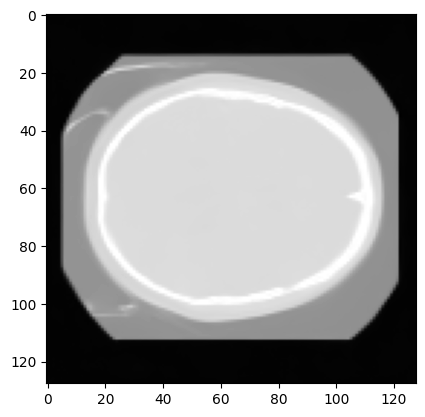

In [54]:
epoch = 100
diff_outs = [None] * n_test_new
fold = 1

for i in range(n_test_new):
  diff_out = np.load(f'./diff_results/fold{fold}/x0_number_{i+1}_epoch_{epoch}.npy')
  diff_out = np.reshape(diff_out, (img_size, img_size, 1))
  plt.imshow(diff_out, cmap='gray')
  # diff_out = np.reshape(diff_out, (1, img_size, img_size))
  # diff_out = torch.tensor(diff_out)
  # diff_outs[i] = diff_out.unsqueeze(0)


path = f'ct_test{fold}.hdf5'
f = h5py.File(path,'r')
ct_test_fold = f['data']

In [49]:
# pip install pytorch-ignite

In [50]:
from ignite.metrics import PSNR, SSIM
from collections import OrderedDict

import torch
from torch import nn, optim

from ignite.engine import *
from ignite.handlers import *
from ignite.metrics import *
from ignite.utils import *
from ignite.contrib.metrics.regression import *
from ignite.contrib.metrics import *

# create default evaluator for doctests

def eval_step(engine, batch):
    return batch

default_evaluator = Engine(eval_step)

In [51]:
targets = [None] * n_test_new

for i in range(n_test_new):
  ct_sample = ct_test_fold[i]
  ct_sample = np.reshape(ct_sample, (1, img_size, img_size))
  ct_sample = torch.tensor(ct_sample)
  targets[i] = ct_sample.unsqueeze(0)


In [53]:
metric = SSIM(data_range=1.0)
metric.attach(default_evaluator, 'ssim')


sum_ssims = 0

for i in range(n_test_new):
  state = default_evaluator.run([[diff_outs[i], targets[i]]])
  ssim_value = state.metrics['ssim']
  print(ssim_value)
  sum_ssims += ssim_value

avg_ssim = sum_ssims / n_test_new

# avg_ssim

0.7576877817916952
0.8786321989105628
0.6699464118489906
0.6633016977424009
0.5785646019706157
0.5791178351204944
0.8534248386369652
0.7666755865992005
0.6983905736118386
0.7200167001587716


In [ ]:
# average

80: 0.58
85: 0.61
90: 0.61
95: 0.58
100: 0.71